# Unraveling Sleep Mysteries: Predicting Sleep Disorders Using Key Indicators

## Introduction ##
Sleep disorders like insomnia and sleep apnea disrupt standard sleep patterns, impacting overall well-being and daily functioning. Insomnia involves difficulty falling or staying asleep, leading to fatigue, irritability, and impaired cognitive function. Sleep apnea, characterized by pauses in breathing during sleep, causes fragmented sleep, loud snoring, and daytime sleepiness. Risk factors include obesity and anatomical airway abnormalities. This study aims to predict these disorders using indicators like age, physical activity, and sleep duration to enhance early detection and intervention, ultimately improving sleep health and quality of life.

The dataset we will use is called the [Sleep Health and Lifestyle Dataset](https://www.kaggle.com/datasets/uom190346a/sleep-health-and-lifestyle-dataset/data). It comprises 374 rows and 13 columns containing variables related to sleep, health and individual habits (there are duplicate rows). Specifically, the variables include gender, age, occupation, sleep duration, quality of sleep, physical activity, stress level, BMI Category, blood pressure, heart rate, daily steps, and sleep disorder.



## Tidying the Data
Firstly, we must read, wrangle and clean the data to prepare for our analysis.
We filter the variables we will use and set the target variable as a categorical variable.
This step will use functions including `read_csv`, `colnames`, `select`, `mutate`, and `as_factor`.

After that, we must split our data set into training and testing sets for later classification.
In addition, we need to summarize the average value of four predictors (age, physical activity, sleep duration, and heart rate) in each of the three groups (people without sleep disorder, with insomnia, and with sleep apnea) so that it is easier to compare the differences.
This step will use functions including `initial_split`, `group_by`, `mutate`, and `summarize`.

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(gridExtra)
options(repr.matrix.max.rows = 6)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [2]:
set.seed(2005)

#Read in our data.
sleep_data_untidy <- read_csv("https://raw.githubusercontent.com/d-alex171/dsci-project/main/Sleep_health_and_lifestyle_dataset.csv")
colnames(sleep_data_untidy) <- c("person_ID", "gender", "age", "occupation", "sleep_duration", "sleep_quality", "physical_activity", "stress_level", "BMI", "blood_pressure", "heart_rate", "daily_steps", "sleep_disorder")
sleep_data_untidy

Rows: 374 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Gender, Occupation, BMI Category, Blood Pressure, Sleep Disorder
dbl (8): Person ID, Age, Sleep Duration, Quality of Sleep, Physical Activity...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


person_ID,gender,age,occupation,sleep_duration,sleep_quality,physical_activity,stress_level,BMI,blood_pressure,heart_rate,daily_steps,sleep_disorder
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,None
2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
372,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
373,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
374,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea


**Table 1: Untidy Imported Dataset** 

In [3]:
#Tidy the data.
sleep_data <- sleep_data_untidy |>
    select(age, sleep_duration, physical_activity, blood_pressure, heart_rate, sleep_disorder) |>
    mutate(sleep_disorder = as_factor(sleep_disorder)) |>
    mutate(sleep_disorder = fct_recode(sleep_disorder, "Insomnia" = "2", "Sleep Apnea" = "1", "None" = "0")) |>
    separate(col = blood_pressure,
                           into = c("systolic_bp", "diastolic_bp"),
                           sep = "/") |>
    mutate(across(systolic_bp : diastolic_bp, as.integer))
sleep_data

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `sleep_disorder = fct_recode(...)`.
Caused by warning:
! Unknown levels in `f`: 2, 1, 0”


age,sleep_duration,physical_activity,systolic_bp,diastolic_bp,heart_rate,sleep_disorder
<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<fct>
27,6.1,42,126,83,77,None
28,6.2,60,125,80,75,None
28,6.2,60,125,80,75,None
⋮,⋮,⋮,⋮,⋮,⋮,⋮
59,8.1,75,140,95,68,Sleep Apnea
59,8.1,75,140,95,68,Sleep Apnea
59,8.1,75,140,95,68,Sleep Apnea


**Table 2: Tidy Imported Dataset with Columns To Use for the Analysis** 

In [4]:
#Summarize the data set.
sleep_split <- initial_split(sleep_data, prop = 0.75, strata = sleep_disorder)
sleep_train <- training(sleep_split)
sleep_test <- testing(sleep_split)

sleep_train_means <- sleep_train |>
    group_by(sleep_disorder) |>
    summarize(mean_age = mean(age, na.rm = TRUE), mean_sleep_duration = mean(sleep_duration, na.rm = TRUE), 
              mean_PA = mean(physical_activity, na.rm = TRUE), mean_HR = mean(heart_rate, na.rm = TRUE))
sleep_train_means

sleep_disorder,mean_age,mean_sleep_duration,mean_PA,mean_HR
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
None,38.82317,7.329878,57.31098,68.96341
Sleep Apnea,48.98276,6.989655,73.43103,73.05172
Insomnia,44.10526,6.601754,46.49123,70.07018


**Table 3: Mean Parameter Values for each Sleep Disorder** 

## Exploratory Data Visualization

In the following study, we are trying to investigate a relationship between the presence of sleep disorders, such as insomnia and sleep apnea, and various factors, including age, sleep duration, occupation and amount of physical activity. The following plot demonstrates the relationship between the number of cases of Insomnia and Sleep Apnea, and age category of the patients.

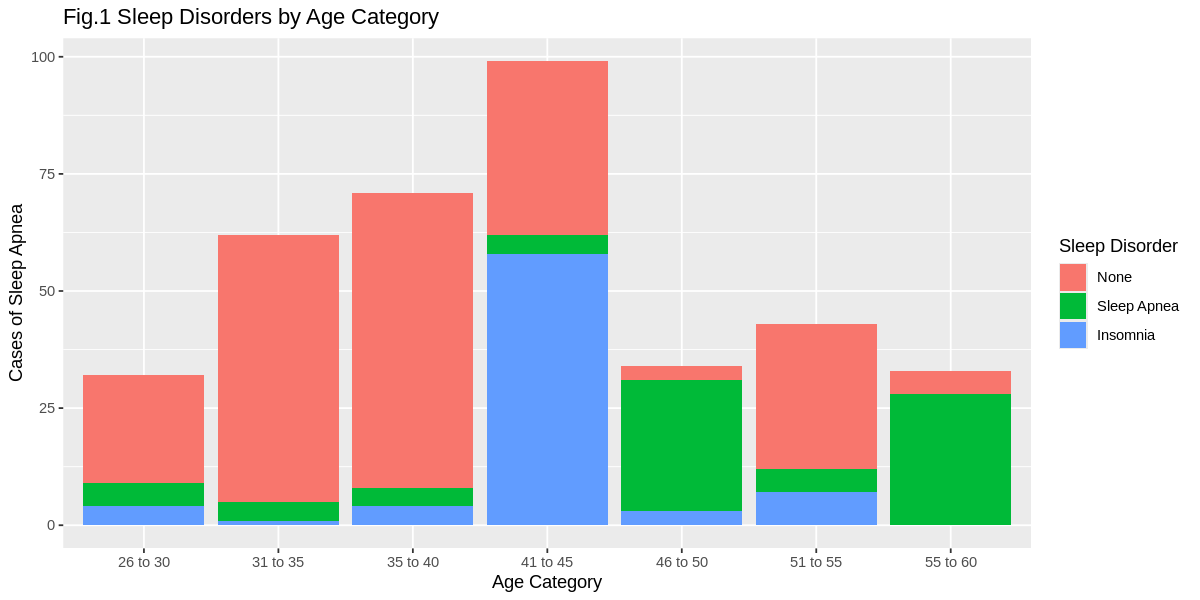

In [5]:
sleep_data_age_category <- sleep_data |>
    mutate(age_cat = case_when(age >= 20 & age <= 25 ~ "20 to 25",
                               age >= 26 & age <= 30 ~ "26 to 30",
                               age >= 31 & age <= 35 ~ "31 to 35",
                               age >= 36 & age <= 40 ~ "35 to 40",
                               age >= 41 & age <= 45 ~ "41 to 45",
                               age >= 46 & age <= 50 ~ "46 to 50",
                               age >= 51 & age <= 55 ~ "51 to 55",
                               age >= 55 & age <= 60 ~ "55 to 60"))

options(repr.plot.width = 10, repr.plot.height = 5)

sleep_plot_age <- sleep_data_age_category |>
    ggplot(aes(x=age_cat)) +
    geom_bar(aes(fill=sleep_disorder)) +
    labs(x = "Age Category", y = "Cases of Sleep Apnea", fill="Sleep Disorder") +
    ggtitle("Fig.1 Sleep Disorders by Age Category")

sleep_plot_age

As we can see from the following visualization, cases of insomnia peak for people between the ages of 41 and  45, whereas sleep apnea peaks at the ages of 46 to 50 and 55 to 60. Therefore, there is a very strong correlation between age and a particular sleep disorder. Furthermore, we can investigate the correlation between the duration of sleep and the presence of sleep disorders.

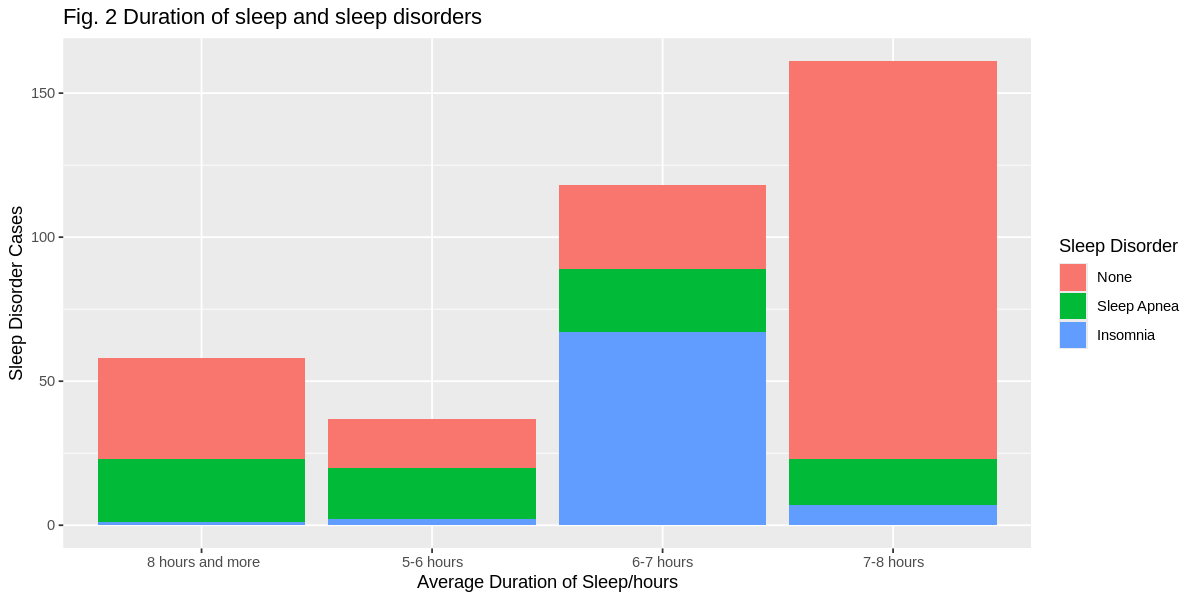

In [6]:
sleep_data_duration_category <- sleep_data |>
    mutate(duration_cat = case_when(sleep_duration >= 5 & sleep_duration <= 6 ~ "5-6 hours",
                               sleep_duration > 6 & sleep_duration <= 7 ~ "6-7 hours",
                               sleep_duration > 7 & sleep_duration <= 8 ~ "7-8 hours",
                               sleep_duration > 8 ~ " 8 hours and more"))

sleep_plot_duration <- sleep_data_duration_category |>
    ggplot(aes(x = duration_cat)) +
    geom_bar(aes(fill=sleep_disorder)) +
    labs(x="Average Duration of Sleep/hours", y="Sleep Disorder Cases", fill="Sleep Disorder") +
    ggtitle("Fig. 2 Duration of sleep and sleep disorders")

sleep_plot_duration

As it can be seen from the following graphs, there is a stronger correlation between the presence of insomnia and duration of sleep rather of sleep apnea, as more people who sleep between 6 to 7 hours tend to have insomnia.

## KNN Classification Analysis
To investigate our research question, k-nearest neighbour classifcation was performed using the `tidymodels` package. To find the optimal k value, we used 5-fold cross-validation on the training set.

First, we need to reprocess the data to standardize it. We used the `recipe` framework with the training data to do this. Scaling was added with `step_scale`, and centring was added with `step_center.` 

In [7]:
# Create a recipe to standardize training data
sleep_recipe <- recipe(sleep_disorder ~., data = sleep_train) |>
                    step_center(all_predictors()) |>
                    step_scale(all_predictors())

We then created the knn model specifications by calling the `nearest_neighbor` function. To tune the model, `tune()` was used. 

In [8]:
# knn specifications with tuning
sleep_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                set_engine("kknn") |>
                set_mode("classification")

Next, we performed the 5-fold cross-validation on the training data using `vfold_cv` to split the data into five folds (`v`). The `strata` is set to `sleep_disorder`, our categorical label variable. We then performed the workflow analysis. The `tune_grid` function was used to help estimate the classifier accuracy for the range of k values.

In [9]:
# 5-fold cross-validation
sleep_vfold <- vfold_cv(sleep_train, v = 5, strata = sleep_disorder)

# Create a workflow with k ranging from 1 to 30
gridvals <- tibble(neighbors = seq(from = 1, to = 30))

sleep_results <- workflow() |>
                    add_recipe(sleep_recipe) |>
                    add_model(sleep_spec) |>
                    tune_grid(resamples = sleep_vfold, grid = gridvals) |>
                    collect_metrics()

accuracies <- sleep_results |>
                filter(.metric == "accuracy")

accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.7849095,5,0.01259329,Preprocessor1_Model01
2,accuracy,multiclass,0.7919270,5,0.01146802,Preprocessor1_Model02
3,accuracy,multiclass,0.8955980,5,0.02507662,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
28,accuracy,multiclass,0.8707140,5,0.03245863,Preprocessor1_Model28
29,accuracy,multiclass,0.8601877,5,0.03075052,Preprocessor1_Model29
30,accuracy,multiclass,0.8496614,5,0.03254585,Preprocessor1_Model30


**Table 4: Accuracies of the training model for each number of neighbours from 1 to 50** 

To choose the optimal number of neighbours, we decided to plot the k versus to accuracy using`ggplot`. 

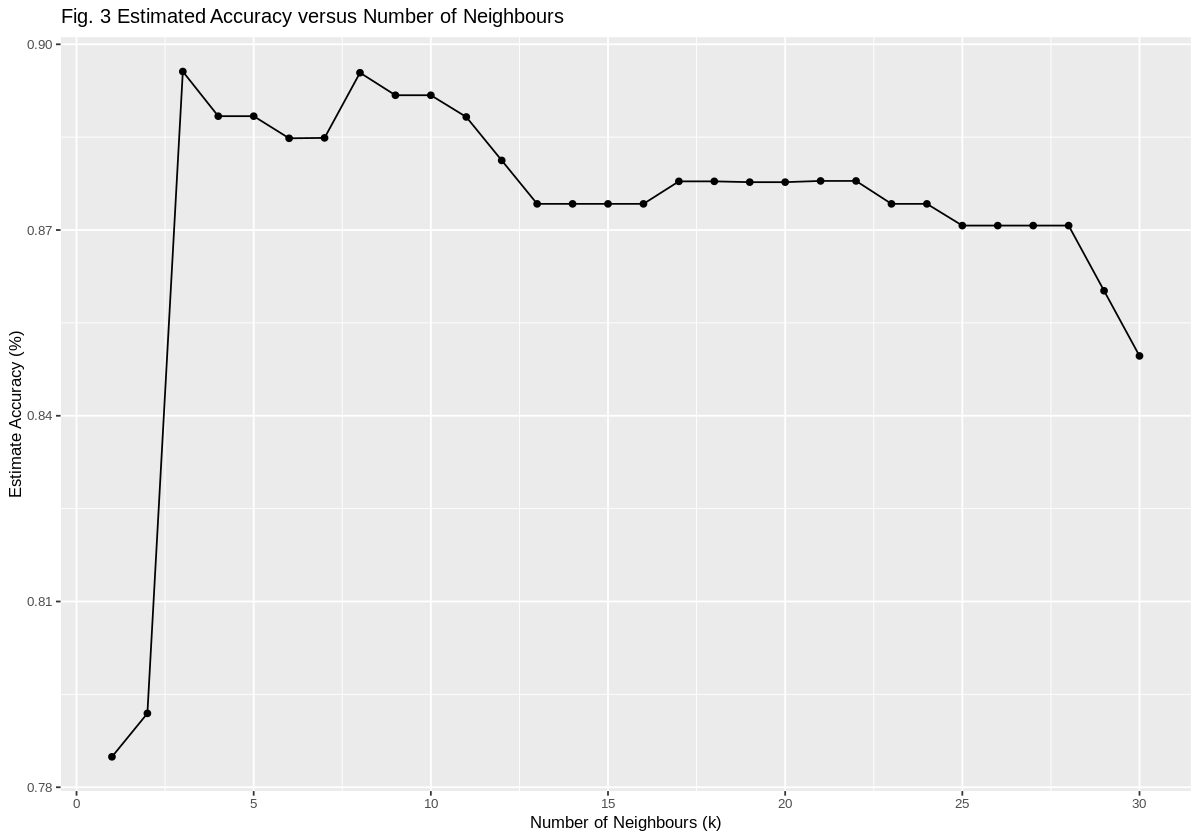

In [10]:
options(repr.plot.height = 7, repr.plot.width = 10)
k_plot <- accuracies |>
            ggplot(aes(x = neighbors, y = mean)) +
            geom_point() +
            geom_line() +
            xlab("Number of Neighbours (k)") +
            ylab("Estimate Accuracy (%)") +
            scale_x_continuous(breaks = seq(0, 30, by = 5)) +
            ggtitle("Fig. 3 Estimated Accuracy versus Number of Neighbours") +
            theme(text = element_text(size = 10))

k_plot

Based on this visualization, the optimal k values seem to be 3 or 8. Because they look so close in the visualization, we used `slice` to get a more specific read on the accuracies for comparison 

In [11]:
top_k_vals <- accuracies |>
                slice(3, 8) |>
                select(neighbors, mean)
top_k_vals

neighbors,mean
<int>,<dbl>
3,0.895598
8,0.895403


**Table 5: Top 2 best accuracies and associated number of neighbors** 

Based on this, the optimal k value is k=3, which has the highest accuracy. This k value will be used in our final model.

To build this final model, we created a new knn model specification, now with k=3, which was determined with cross-validation. To fit the model on the sleep data, the model specification and the data are set to the `fit` function. 

In [12]:
# Knn classification with optimal k
sleep_optimal_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
                        set_engine("kknn") |>
                        set_mode("classification")

sleep_fit <- workflow() |>
                add_recipe(sleep_recipe) |>
                add_model(sleep_optimal_spec) |>
                fit(data = sleep_train)

This final model was used to predict the test data, and the accuracy was tested by computing the metrics. To evaluate our classifcation model, we looked at the accuracy and created a confusion matrix. 

In [13]:
# Predictions on test data
sleep_predictions <- predict(sleep_fit, sleep_test) |>
                        bind_cols(sleep_test)

sleep_metrics <- sleep_predictions |>
                    metrics(truth = sleep_disorder, estimate = .pred_class) |>
                    filter(.metric == "accuracy")
sleep_metrics

sleep_confusion_matrix <- sleep_predictions |>
                            conf_mat(truth = sleep_disorder, estimate = .pred_class)
sleep_confusion_matrix

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.8947368


             Truth
Prediction    None Sleep Apnea Insomnia
  None          53           0        3
  Sleep Apnea    2          18        3
  Insomnia       0           2       14

**Table 6: Confusion Matrix of the model on the testing dataset** 

## Final Visualization

In [14]:
sleep_predictions

.pred_class,age,sleep_duration,physical_activity,systolic_bp,diastolic_bp,heart_rate,sleep_disorder
<fct>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<fct>
None,27,6.1,42,126,83,77,None
None,28,6.2,60,125,80,75,None
Sleep Apnea,29,6.3,40,140,90,82,Insomnia
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Sleep Apnea,59,8.0,75,140,95,68,Sleep Apnea
Sleep Apnea,59,8.1,75,140,95,68,Sleep Apnea
Sleep Apnea,59,8.0,75,140,95,68,Sleep Apnea


**Table 7: Testing dataset with the associated predictions** 

In [15]:
predictions_count <- sleep_predictions |>
semi_join(sleep_test) |>
group_by(sleep_disorder, .pred_class) |>
summarise(n = n())

predictions_count
      

Joining with `by = join_by(age, sleep_duration, physical_activity, systolic_bp,
diastolic_bp, heart_rate, sleep_disorder)`
`summarise()` has grouped output by 'sleep_disorder'. You can override using
the `.groups` argument.


sleep_disorder,.pred_class,n
<fct>,<fct>,<int>
None,None,53
None,Sleep Apnea,2
Sleep Apnea,Sleep Apnea,18
⋮,⋮,⋮
Insomnia,None,3
Insomnia,Sleep Apnea,3
Insomnia,Insomnia,14


**Table 8: Number of Accurate Predictions** 



|sleep_disorder |.pred_class |  n|
|:--------------|:-----------|--:|
|None           |None        | 53|
|None           |Sleep Apnea |  2|
|Sleep Apnea    |Sleep Apnea | 18|
|Sleep Apnea    |Insomnia    |  2|
|Insomnia       |None        |  3|
|Insomnia       |Sleep Apnea |  3|
|Insomnia       |Insomnia    | 14|

List of 1
 $ text:List of 11
  ..$ family       : NULL
  ..$ face         : NULL
  ..$ colour       : NULL
  ..$ size         : num 13
  ..$ hjust        : NULL
  ..$ vjust        : NULL
  ..$ angle        : NULL
  ..$ lineheight   : NULL
  ..$ margin       : NULL
  ..$ debug        : NULL
  ..$ inherit.blank: logi FALSE
  ..- attr(*, "class")= chr [1:2] "element_text" "element"
 - attr(*, "class")= chr [1:2] "theme" "gg"
 - attr(*, "complete")= logi FALSE
 - attr(*, "validate")= logi TRUE

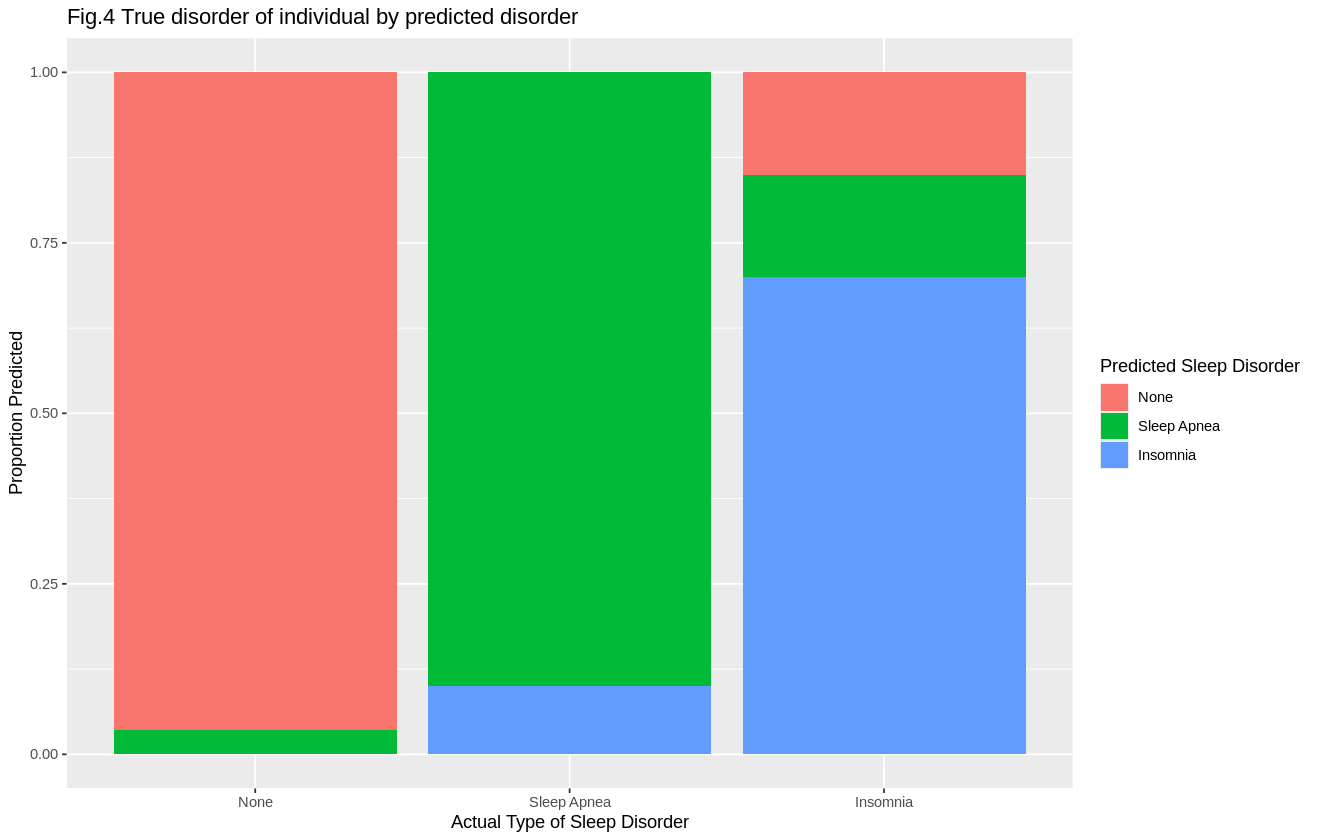

In [16]:
predictions_count_table <- knitr::kable(predictions_count)
predictions_count_table


options(repr.plot.width = 11)
sleep_prediction_plot <- ggplot(predictions_count, aes( x = sleep_disorder, y = n, fill = .pred_class)) +
geom_bar(stat = "identity", position = "fill") +
labs( x = "Actual Type of Sleep Disorder", y = "Proportion Predicted", fill = "Predicted Sleep Disorder") +
ggtitle("Fig.4 True disorder of individual by predicted disorder")
theme(text = element_text(size = 13)) 

sleep_prediction_plot
      

# Discussions #

### Summary of findings ###


Our analysis of the sleep disorder dataset corroborates our expectations regarding the significance of various predictors in discerning between individuals with different sleep disorders and those without. We identified age, physical activity, and blood pressure as particularly influential predictors in our classification task.


In [17]:
accuracy <- (53 + 18 + 14)/(53 + 2 + 18 + 2 + 3 + 3 + 14)
accuracy

[1] 0.8947368

Within the dataset, our classifier exhibited a commendable accuracy rate of 0.8947, showcasing its proficiency in differentiating between individuals with sleep apnea, those experiencing insomnia, and those devoid of any such disorders, with an 89.47% success rate. This achievement underscores the classifier's capability to make nuanced distinctions within these health categories. Moreover, a thorough evaluation of precision and recall metrics will provide a comprehensive understanding of its effectiveness in classifying individuals accurately.

In [18]:
precision <- sleep_predictions |>
precision(truth = sleep_disorder, estimate = .pred_class)
precision

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,macro,0.8680124


**Table 9: Precision** 

Precision, reflecting the reliability of our model's predictions, achieved a value of 0.868, suggesting a 13.3% chance of false positives. This implies a small likelihood of misclassifying individuals without sleep disorders as having one, possibly resulting in unnecessary interventions.

In [19]:
recall <- sleep_predictions |>
recall(truth = sleep_disorder, estimate = .pred_class)
recall

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,macro,0.8545455


Likewise, a recall value of 0.855 showcases our model's consistent identification of individuals with sleep disorders, with a 14.6% risk of false negatives. This underscores the possibility of our model overlooking some cases of sleep disorders, potentially delaying necessary interventions.

From the table, we observe that insomnia has a precision of 0.875 and a recall of 0.7 when evaluated separately. This indicates high accuracy in identifying individuals with insomnia, but also suggests that around 30% of actual cases may be missed. While the high precision instills confidence, the moderate recall highlights the need for improved sensitivity to capture more true positives. Achieving a balance between precision and recall is vital for the model's effectiveness in clinical practice.

The table reveals that when analyzed independently, sleep apnea shows a precision of 0.837 and a recall o f0.91. This means the model correctly identifie s90% of all thl actual cases of sleep apnea but has a precision of 0.77, indicating that 77% of the predicted cases are true positives. While the model effectively capturesmostl instances of sleep apnea, the presence of false positives suggests room for improvement in accurately distinguishing between true and false positives.
 
For insomnia, the model exhibits superior precision (0.875) yet comparatively lower recall (0.7), denoting precise identification of predicted cases while potentially overlooking certain actual instances. Conversely, in the case of sleep apnea, precision slightly diminishes (0.783) while recall improves (0.9), indicating proficient identification of most actual cases with some occurrence of false positives. Striking a balance between precision and recall is paramount for refining the model's efficacy in clinical applications



Despite an overall misclassification rate of 10.5%, our analysis indicates the promise of our model in predicting sleep disorders. However, further refinement and validation are essential to enhance its accuracy and reliability in real-world scenarios.


# Potential Impacts #
## Healthcare Interventions
Understanding the intricate relationship between lifestyle factors and sleep disorders holds significant promise for healthcare interventions. With this analysis, healthcare providers can tailor interventions that target specific lifestyle modifications to improve sleep health. For instance, individuals identified as having insufficient physical activity levels coupled with poor sleep quality may benefit from personalized exercise regimens designed to promote better sleep patterns. Similarly, those with hig- stress levels could be offered stress management techniques or cognitive behaviuoral therapy (CBT) to alleviate sleep disturbances

## Technological Innovations

Insights gleaned from predictive modelling can propel advancements in digital health technologies focused on monitoring and enhancing sleep health. Wearable devices with slee- tracking features could fuse personalized insights from predictive models, offering users instant feedback and practical suggestions to refine their sleep routines. Moreover, mobile apps could be designed to deliver customized behaviuoral interventions tailored to individual risk profiles, empowering users with targeted strategies to tackle sleep-related issues and monitor their improvement over time

## Clinical Practice 
In clinical settings, the predictive model developed in this analysis becomes a useful tool for healthcare providers to assess and manage sleep disorders. By using predictive analytics in their daily practice, providers can speed up diagnosis, identify peopleat high risk of sleep problems, and start treatments early to prevent health issues. This proactive approach not only helps patients get better but also ensurese that resources are used where they're needed most in the healthcare system.

# Future Questions
- Improving Model Accuracy with Demographic Factors:
Exploring how additional demographic variables affect the predictive model's accuracy offers an opportunity to enhance its performance and applicability. By integrating factors such as socioeconomic status, education, or location, the model can better account for the varied influences on sleep health across different populations .Furthermore, the research shows that one of the sleep disorders predicted by the model, insomnia, is more prevalent for people suffering from mental illnesses (Sexton-Radek & Graci, 2022). In addition to that, there is a possibility that anti-depressant medicine may cause insomnia as well (Khawaja, 2021).  This comprehensive approach may strengthen the model's capacity to identify high-risk individuals and tailor interventions to meet specific demographic requirements more effectivlye. 

- Health Disparities and Sleep Inequities:
Examining sleep health gaps among demographic groups like racial minorities, low-income populations, and those with disabilities can reveal systemic inequalities in accessing quality sleep care. By understanding how social factors intersect with sleep disparities, we can develop strategies to promote health equity in sleep research, policy, and practice

- Long-term Impact of Lifestyle Interventions:
Studying how lifestyle changes affect sleep health over time can reveal the lasting effectiveness of behauvior modifications. By investigating whether improvements from interventions like exercise or stress reduction endure over months or years, we can develop strategies for sustaining healthy sleep habits and preventing relap.ly

## References
Sexton-Radek, K., Graci, G., & ProQuest (Firm). (2021). Sleep disorders: Elements, history, treatments, and research (1st ed.). ABC-CLIO. https://doi.org/10.5040/9798216015314

Sleep disorders in selected psychiatric settings: A clinical casebookIn Khawaja I. S., Hurwitz T. D.(Eds.), . Springer International Publishing. https://doi.org/10.1007/978-3-030-59309-4

Tharmalingam, L. (2023, September 18). Sleep health and lifestyle dataset. Kaggle. 
https://www.kaggle.com/datasets/uom190346a/sleep-health-and-lifestyle-dataset/data 
